In [ ]:
!gdown https://drive.google.com/uc?id=1WsLkQKdcj2yZblcLbo9o5zVWMkq7G8A8

Downloading...
From (original): https://drive.google.com/uc?id=1WsLkQKdcj2yZblcLbo9o5zVWMkq7G8A8
From (redirected): https://drive.google.com/uc?id=1WsLkQKdcj2yZblcLbo9o5zVWMkq7G8A8&confirm=t&uuid=96c218d3-c1f4-4e23-8810-a7bbcf0bd828
To: /content/chessData.csv.zip
100% 151M/151M [00:02<00:00, 54.1MB/s]


In [ ]:
!unzip -q chessData.csv.zip

replace chessData.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
my_data_df = pd.read_csv('chessData.csv')

In [ ]:
# Remove checkmate
my_data_df = my_data_df[~my_data_df.iloc[:, -1].astype(str).str.startswith('#')]

In [ ]:
def parse_board(fen_string):
    piece_to_index = [{'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5, 'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11},
                      {'P': 6, 'N': 7, 'B': 8, 'R': 9, 'Q': 10, 'K': 11, 'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5}]

    # Create an empty numpy array with shape (8, 8, 12)
    chessboard = np.zeros((8, 8, 12), dtype=int)

    # Split the FEN string into its components
    fen_parts = fen_string.split(' ')
    board_part = fen_parts[0]

    turn = 0 if fen_parts[1] == "w" else 1

    # Convert the FEN board string to a numpy array
    row = 0
    col = 0
    for char in board_part:
        if char == '/':
            row += 1
            col = 0
        elif char.isdigit():
            col += int(char)
        else:
            piece_index = piece_to_index[turn][char]
            chessboard[row if turn == 0 else 7 - row, col if turn == 0 else 7 - col, piece_index] = 1
            col += 1

    return chessboard

def parse_misc_data(fen_string):
    # Split the FEN string into its components
    fen_parts = fen_string.split(' ')

    # Normalize castling data
    piece_to_index = {'K': 0, 'Q': 1, 'k': 2, 'q': 3}
    castle_array = np.zeros(4, dtype=int)
    for c in fen_parts[2]:
        try:
            castle_array[piece_to_index[c]] = 1
        except KeyError:
            pass

    # Normalize en passant data
    en_passent_array = np.zeros((8, 8), dtype=int)
    if fen_parts[3] != "-":
        row = int(fen_parts[3][1]) - 1
        col = ord(fen_parts[3][0]) - ord('a')
        en_passent_array[row, col] = 1

    return np.concatenate([castle_array, np.ndarray.flatten(en_passent_array)])

def matrix_to_chessboard(matrix: np.ndarray) -> None:
    # Define channel to piece mappings
    channel_to_piece = {
        0: 'P', 1: 'N', 2: 'B', 3: 'R', 4: 'Q', 5: 'K',  # White pieces
        6: 'p', 7: 'n', 8: 'b', 9: 'r', 10: 'q', 11: 'k'  # Black pieces
    }

    # Initialize an empty 8x8 board
    board = [['.' for _ in range(8)] for _ in range(8)]

    # Iterate over the matrix to reconstruct the board
    for row in range(8):
        for col in range(8):
            for channel in range(12):
                if matrix[row, col, channel] == 1:
                    board[row][col] = channel_to_piece[channel]

    # Print the board
    for row in board:
        print(' '.join(row))

def parse_advantage(advantage_str):
    return np.cbrt(int(advantage_str.lstrip('\ufeff')) / 100)

print(matrix_to_chessboard(parse_board('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1')))
print(matrix_to_chessboard(parse_board('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR b KQkq - 0 1')))
print(parse_misc_data('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq e4 0 1'))
print(parse_misc_data('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq e4 0 1').shape)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
None
r n b k q b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B K Q B N R
None
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(68,)


In [ ]:
class ChessDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, indices, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = my_data_df
        self.indices = indices
        self.on_epoch_end()

        # Fit the scaler on the evaluation data for the entire dataset
        # self.data['Evaluation'] = self.scaler.fit_transform(self.data[['Evaluation']])

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.data.iloc[batch_indices]

        X, y = self.__data_generation(batch_data)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        X_board = np.array([parse_board(fen) for fen in batch_data['FEN']])
        X_misc = np.array([parse_misc_data(fen) for fen in batch_data['FEN']])
        y = np.array([parse_advantage(advantage) for advantage in batch_data['Evaluation']])
        return [X_board, X_misc], y

In [ ]:
board_input_layer = tf.keras.layers.Input(shape=(8, 8, 12), name="board")

board_conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', data_format='channels_last')(board_input_layer)
board_conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', data_format='channels_last')(board_conv1)
board_conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', data_format='channels_last')(board_conv2)

board_flatten = tf.keras.layers.GlobalAveragePooling2D()(board_conv3)

misc_input_layer = tf.keras.layers.Input(shape=(68,), name="misc")

misc_dense1 = tf.keras.layers.Dense(128, activation='relu')(misc_input_layer)
misc_dense2 = tf.keras.layers.Dense(64, activation='relu')(misc_dense1)

concat_layer = tf.keras.layers.Concatenate()([board_flatten, misc_dense2])

hidden_layer1 = tf.keras.layers.Dense(256, activation='relu')(concat_layer)
hidden_layer2 = tf.keras.layers.Dense(128, activation='relu')(hidden_layer1)
hidden_layer3 = tf.keras.layers.Dense(64, activation='relu')(hidden_layer2)

output_layer = tf.keras.layers.Dense(1, activation=tf.math.atan)(hidden_layer3)

model = tf.keras.Model(inputs=[board_input_layer, misc_input_layer], outputs=output_layer)

opt = tf.keras.optimizers.AdamW(learning_rate=0.01)

def tan_mae(y_true, y_pred):
    return tf.reduce_mean(tf.math.abs(100 * tf.math.tan(y_pred) - 100 * tf.math.tan(y_true)))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

model.compile(optimizer=opt, loss=mse, metrics=[tan_mae])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board (InputLayer)          [(None, 8, 8, 12)]           0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 6, 6, 32)             3488      ['board[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)           (None, 4, 4, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 misc (InputLayer)           [(None, 68)]                 0         []                            
                                                                                            

In [ ]:
num_samples = len(my_data_df)

# Define the validation and test split
validation_split = 0.2
test_split = 0.01
num_test_samples = int(num_samples * test_split)
num_val_samples = int(num_samples * validation_split)
num_train_samples = num_samples - num_val_samples - num_test_samples

# Generate indices and split them
indices = np.arange(num_samples)
np.random.shuffle(indices)
train_indices = indices[:num_train_samples]
val_indices = indices[num_train_samples:num_train_samples + num_val_samples]
test_indices = indices[num_train_samples + num_val_samples:]

In [ ]:
train_generator = ChessDataGenerator(indices=train_indices, batch_size=6400, shuffle=False)
val_generator = ChessDataGenerator(indices=val_indices, batch_size=6400, shuffle=False)
test_generator = ChessDataGenerator(indices=test_indices, batch_size=num_test_samples, shuffle=False)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
1576/1576 [==============================] - 617s 389ms/step - loss: 1.5917 - tan_mae: 640.0687 - val_loss: 1.5900 - val_tan_mae: 639.6366
Epoch 2/10
1576/1576 [==============================] - 575s 365ms/step - loss: 1.5908 - tan_mae: 639.9949 - val_loss: 1.5901 - val_tan_mae: 639.6366
Epoch 3/10
1576/1576 [==============================] - 582s 369ms/step - loss: 1.5908 - tan_mae: 639.9953 - val_loss: 1.5903 - val_tan_mae: 639.6393
Epoch 4/10
1576/1576 [==============================] - 617s 392ms/step - loss: 1.5908 - tan_mae: 639.9937 - val_loss: 1.5900 - val_tan_mae: 639.6448
Epoch 5/10
1576/1576 [==============================] - 613s 389ms/step - loss: 1.5909 - tan_mae: 640.0035 - val_loss: 1.5902 - val_tan_mae: 639.6729
Epoch 6/10
1576/1576 [==============================] - 573s 364ms/step - loss: 1.5909 - tan_mae: 639.9982 - val_loss: 1.5900 - val_tan_mae: 639.6190
Epoch 7/10
1576/1576 [==============================] - 607s 385ms/step - loss: 1.5908 - tan_mae: 63

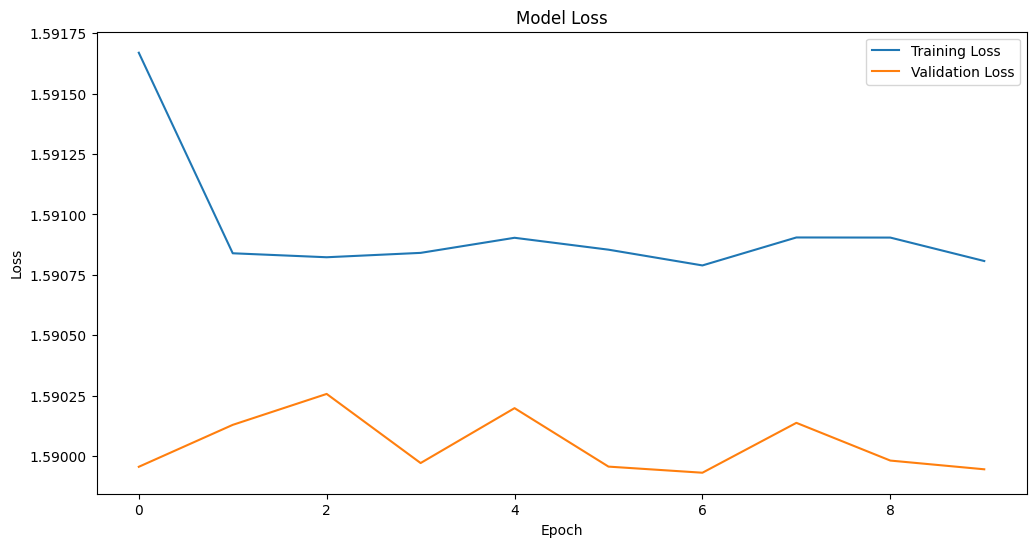

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.evaluate(test_generator)

1/1 [==============================] - 10s 10s/step - loss: 1.5993 - tan_mae: 648.3939


[1.5993149280548096, 648.3938598632812]